Parametrization of the Track Energy Resolution
==============================================

The energy resolution $P(E_{reco}| E_{true})$ is obtained from the two year diffuse data release (https://icecube.wisc.edu/science/data/HE_NuMu_diffuse).
There, the effective area is provided as function of $E_{true}$, $\cos\theta$ and $E_{reco}$. Summing over $\cos\theta$ and normalizing per $E_{true}$ then gives $P(E_{reco}| E_{true})$.




In [1]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize
from matplotlib.colors import LogNorm

In [2]:
# Load Aeff data
with h5py.File("../aeff_input_tracks/effective_area.h5", 'r') as f:
    area10 = f['2010/nu_mu/area'][()]
    tE_bin_edges = f['2010/nu_mu/bin_edges_0'][:] # True Energy [GeV]
    cosz_bin_edges = f['2010/nu_mu/bin_edges_1'][:] # cos(zenith)
    rE_bin_edges = f['2010/nu_mu/bin_edges_2'][:] # Reco Energy [GeV]

C:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0, 0.5, 'Reco Energy [GeV]')

C:\Users\Christian\Anaconda3\lib\site-packages\matplotlib\colors.py:1062: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


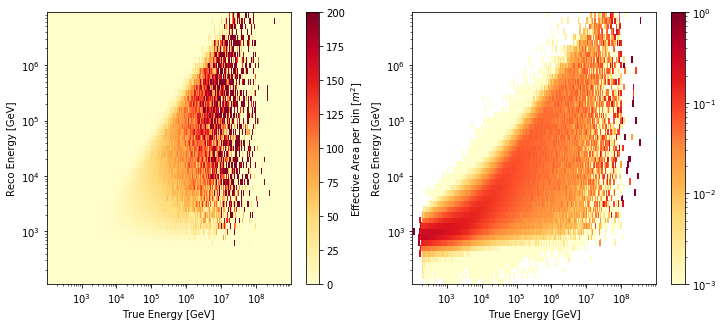

In [3]:
tE_binc = 0.5*(tE_bin_edges[:-1]+tE_bin_edges[1:])
rE_binc = 0.5*(rE_bin_edges[:-1]+rE_bin_edges[1:])

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
cmesh = axs[0].pcolormesh(tE_binc, rE_binc, area10.sum(axis=1).T,
                          vmax=200, cmap=plt.cm.YlOrRd)
cbar = fig.colorbar(cmesh, ax=axs[0])
cbar.set_label("Effective Area per bin [$m^2$]")
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_xlabel("True Energy [GeV]")
axs[0].set_ylabel("Reco Energy [GeV]")

cmesh = axs[1].pcolormesh(tE_binc, rE_binc,
                          area10.sum(axis=1).T / area10.sum(axis=1).T.sum(axis=0),
                          cmap=plt.cm.YlOrRd,
                         norm=LogNorm(vmin=1E-3))
cbar = fig.colorbar(cmesh, ax=axs[1])
#cbar.set_label("Effective Area per bin [$m^2$]")
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_xlabel("True Energy [GeV]")
axs[1].set_ylabel("Reco Energy [GeV]")



In [4]:
class Residuals:
    """
    Helper class for calculating residuals of model compared to data
    """
    def __init__(self, data, model):
        """
        
        Parameters:
        -----------
        data: tuple
            data x- and y coordinates
            
        model: callable
            A callable encoding the model. The callable should take
            `x` as first argument and a parameter list as second argument.
        """
        self.data_x, self.data_y = data
        self.model = model
        
    def __call__(self, params):
        """
        Return the residuals w.r.t to model(params)
        """
        expec = self.model(self.data_x, params)
        #chi2 =  (expec-self.data_y)**2/expec
       
        residuals = expec-self.data_y
        return residuals


Fitting
-------

Fit a lognormal distribution to $P(E_{reco} | E_{true})$ using least squares

In [66]:
logrEbins = np.log10(rE_binc)
fit_params = []
rebin = 3 # Rebin to have higher statistics at upper and lower end of energy range
rebinned_binc = np.zeros(int(len(tE_binc)/rebin))

#model = lambda x, pars: stats.lognorm.pdf(x, scale=pars[0], s=pars[1])
model = lambda x, pars: pars[2]*stats.lognorm.pdf(x, scale=pars[0], s=pars[1]) + (1-pars[2])*stats.expon.pdf(x, loc=pars[3], scale=pars[4])
model = lambda x, pars: pars[2]*stats.lognorm.pdf(x, scale=pars[0], s=pars[1]) + (1-pars[2])*stats.lognorm.pdf(x, scale=pars[3], s=pars[4])
# Fitting loop
for index in range(int(len(tE_binc)/rebin)):
    #Calculate rebinned bin-centers as mean of first and last bin being summed
    rebinned_binc[index] = 0.5*(tE_binc[[index*rebin, rebin*(index+1)-1]]).sum()
    
    #Calculate the energy resolution for this true-energy bin
    e_reso = area10.sum(axis=1)[index*rebin:(index+1)*rebin].sum(axis=0)
    if e_reso.sum() > 0:
        #Normalize to prob. density / bin
        e_reso = e_reso/e_reso.sum() / (logrEbins[1]-logrEbins[0])

        residuals = Residuals((logrEbins, e_reso), model)
        
        #Calculate seed as mean of the resolution to help minimizer
        seed_mu = np.average(logrEbins, weights=e_reso)
        if ~np.isfinite(seed_mu):
            seed_mu = 3

        res = scipy.optimize.least_squares(
            residuals,
            #[seed_mu, 0.02],
            [seed_mu, 0.02, 0.5, seed_mu+1, 0.02],
            bounds=(
                (0, 0.01, 0.49, 0, 0.01),
                (8, 1, 0.5, 8, 1))
            
        )
        if res.x[0] > res.x[3]:
            fit_params.append([res.x[3], res.x[4], res.x[2], res.x[0], res.x[1]])
        else:
            fit_params.append(res.x)
    else:
        fit_params.append([0, 0, 0, 0, 0])
fit_params = np.asarray(fit_params)


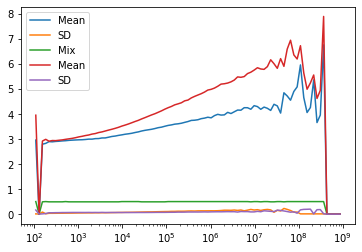

In [67]:
# Plot the fit parameters
plt.plot(rebinned_binc, fit_params[:, 0], label="Mean")
plt.plot(rebinned_binc, fit_params[:, 1], label="SD")
plt.plot(rebinned_binc, fit_params[:, 2], label="Mix")
plt.plot(rebinned_binc, fit_params[:, 3], label="Mean")
plt.plot(rebinned_binc, fit_params[:, 4], label="SD")
plt.semilogx()
plt.legend()

Parametrization of lognormal parameters as function of $log_{10}(E_{true})$ using polynomial
----------------------------------------------------------------------------------

In [68]:
#Min and max values
imin = 5
imax = -15

e_min = rebinned_binc[imin]
e_max = rebinned_binc[imax]

#Degree of polynomial 
polydeg = 5

params_mu = np.polyfit(np.log10(rebinned_binc)[imin:imax], fit_params[:, 0][imin:imax], polydeg)
params_sigma = np.polyfit(np.log10(rebinned_binc)[imin:imax], fit_params[:, 1][imin:imax], polydeg)

Text(0, 0.5, 'SD')

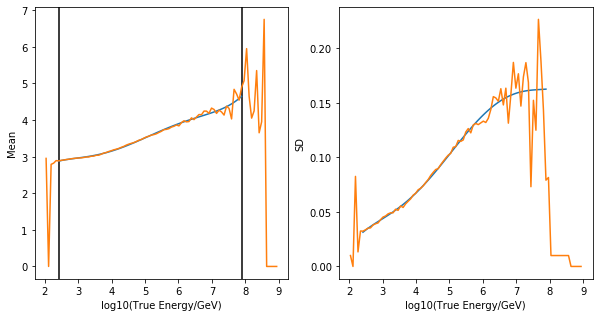

In [69]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].axvline(np.log10(rebinned_binc[imin]), color="k")
axs[0].axvline(np.log10(rebinned_binc[imax]), color="k")
xs = np.linspace(*np.log10(rebinned_binc[[imin, imax]]), num=100)

axs[0].plot(xs, np.poly1d(params_mu)(xs))
axs[0].plot(np.log10(rebinned_binc), fit_params[:, 0], label="Mean")

axs[0].set_xlabel("log10(True Energy/GeV)")
axs[0].set_ylabel("Mean")
axs[1].plot(xs, np.poly1d(params_sigma)(xs))
axs[1].plot(np.log10(rebinned_binc), fit_params[:, 1], label="SD")
axs[1].set_xlabel("log10(True Energy/GeV)")
axs[1].set_ylabel("SD")

Check Parametrizations
-----------------------

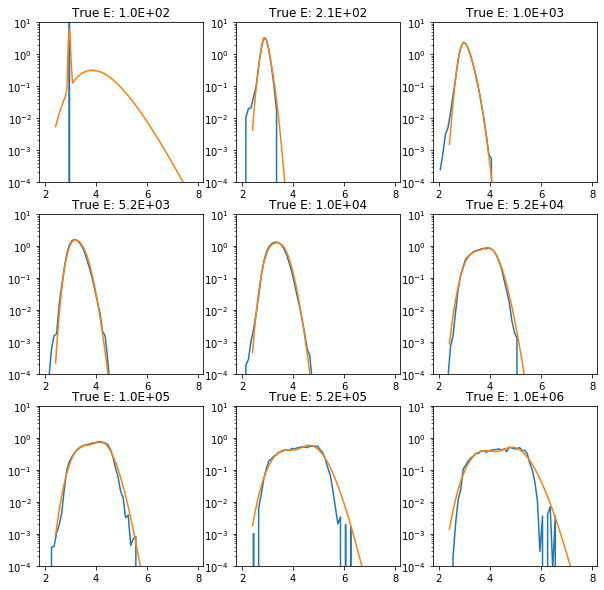

In [70]:
plot_energies = [100, 200, 1E3, 5E3, 1E4, 5E4, 1E5, 5E5, 1E6] # GeV 

#Find true energy bins for the chosen plotting energies
plot_indices = np.digitize(plot_energies, tE_binc)

#Parameters are relative to the rebinned histogram
param_indices = np.digitize(plot_energies, rebinned_binc)

mu_poly = np.poly1d(params_mu)
sigma_poly = np.poly1d(params_sigma)

fig, axs = plt.subplots(3, 3, figsize=(10, 10))

fl_ax = axs.ravel()
for i, pi in enumerate(plot_indices):
    e_reso = area10.sum(axis=1)[int(pi/rebin)*rebin:(int(pi/rebin)+1)*rebin].sum(axis=0)
    e_reso = e_reso/e_reso.sum() / (logrEbins[1]-logrEbins[0])
    fl_ax[i].plot(logrEbins, e_reso)
    
    mu = mu_poly(np.log10(plot_energies[i]))
    sigma = sigma_poly(np.log10(plot_energies[i]))
    res = fit_params[param_indices[i]]
    

    #fl_ax[i].plot(xs, model(xs, scale=mu, s=sigma))
    fl_ax[i].plot(xs, model(xs, res))
    fl_ax[i].set_ylim(1E-4, 10)
    fl_ax[i].set_yscale("log")
    fl_ax[i].set_title("True E: {:.1E}".format(tE_binc[pi]))



In [37]:
np.savez("../aeff_input_tracks/energy_reso_tracks_poly_coeffs.npy",
         mu=params_mu, sigma=params_sigma,
         e_min=e_min, e_max=e_max)

In [1]:
e_min

NameError: name 'e_min' is not defined

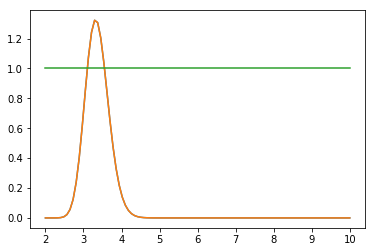

In [712]:

mu = mu_poly(4)
sigma = sigma_poly(4)


mu_t = np.log(mu_poly(4))
sigma_t = sigma_poly(4)


stan_lognorm = lambda x, mu, sigma: 1/np.sqrt(2*np.pi)/sigma/x * np.exp(-0.5*((np.log(x) - mu)/sigma)**2)

xs = np.linspace(2, 10, 100)
plt.plot(xs, scipy.stats.lognorm.pdf(xs, scale=mu, s=sigma))

plt.plot(xs, stan_lognorm(xs, mu_t, sigma_t))

plt.plot(xs, scipy.stats.lognorm.pdf(xs, scale=mu, s=sigma)/stan_lognorm(xs, mu_t, sigma_t))

In [ ]:
np.exp(-0.5*((np.log(x) - mu)/sigma)**2)

In [681]:
scipy.stats.lognorm.pdf(xs, scale=mu, s=sigma**2)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])